In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_link='https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
data = pd.read_csv(data_link)
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


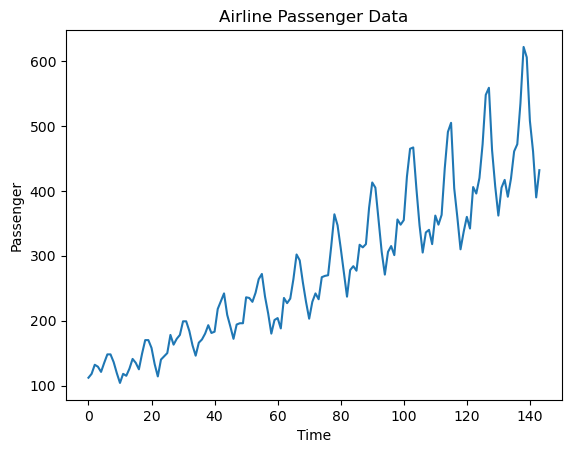

In [3]:
Data = data.iloc[:,1].values
plt.plot(Data)
plt.xlabel("Time")
plt.ylabel("Passenger")
plt.title("Airline Passenger Data")
plt.savefig("Data.pdf")
plt.show()

In [4]:
#reshape
Data = Data.reshape(-1,1)
Data = Data.astype("float32")
Data.shape
# scaling 
scaler = MinMaxScaler(feature_range=(0, 1))
Data = scaler.fit_transform(Data)

In [5]:
def data_gen(dataset, Prev):
    data_X, data_Y = [], []
    for i in range(len(dataset)-Prev-1):
        a = dataset[i:(i+Prev), 0]
        data_X.append(a)
        data_Y.append(dataset[i + Prev, 0])
    return np.array(data_X), np.array(data_Y)
def train_test_split(X, y, testSize):
    idx = int(round(len(X) * (1-testSize)))
    X_train, y_train = X[:idx], y[:idx]
    X_test, y_test = X[idx:], y[idx:]
    return X_train, y_train, X_test, y_test

In [6]:
prev = 1
X, y = data_gen(Data, prev)
print(" Shape of the dataset: X:{},y:{}".format(X.shape, y.shape))
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.33)
print(" Shape of the train test split: X_train:{},y_train:{},X_test:{},y_test{}".format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

 Shape of the dataset: X:(142, 1),y:(142,)
 Shape of the train test split: X_train:(95, 1),y_train:(95,),X_test:(47, 1),y_test(47,)


In [7]:
X_train=X_train.flatten()
y_train=y_train.flatten()
X_test=X_test.flatten()
y_test=y_test.flatten()

In [8]:
def sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def D_Sigmoid(values): 
    return values*(1-values)

def D_tanh(values): 
    return 1. - values ** 2

# generate random array
def RandArray(a, b, *args): 
    np.random.seed(0)
    return np.random.rand(*args) * (b - a) + a

In [104]:
class LossLayer:
    @classmethod
    def loss(self, prediction, label):
        return (prediction[0] - label) ** 2

    @classmethod
    def bottom_diff(self, prediction, label):
        diff = np.zeros_like(prediction)
        diff[0] = 2 * (prediction[0] - label)
        return diff

In [105]:
class LSTM_Parameters:
    def __init__(self, Cell_Count, dimX):
        self.Cell_Count = Cell_Count
        self.dimX = dimX
        Com_Len = dimX + Cell_Count
        # weight and bias initialization
        self.w_g = RandArray(-0.1, 0.1, Cell_Count, Com_Len)
        self.w_i = RandArray(-0.1, 0.1, Cell_Count, Com_Len) 
        self.w_f = RandArray(-0.1, 0.1, Cell_Count, Com_Len)
        self.w_o = RandArray(-0.1, 0.1, Cell_Count, Com_Len)
        self.bais_g = RandArray(-0.1, 0.1, Cell_Count) 
        self.bais_i = RandArray(-0.1, 0.1, Cell_Count) 
        self.bais_f = RandArray(-0.1, 0.1, Cell_Count) 
        self.bais_o = RandArray(-0.1, 0.1, Cell_Count) 

        self.w_g_Dif = np.zeros((Cell_Count, Com_Len)) 
        self.w_i_Dif = np.zeros((Cell_Count, Com_Len)) 
        self.w_f_Dif = np.zeros((Cell_Count, Com_Len)) 
        self.w_o_Dif = np.zeros((Cell_Count, Com_Len)) 
        self.bais_g_Dif = np.zeros(Cell_Count) 
        self.bais_i_Dif = np.zeros(Cell_Count) 
        self.bais_f_Dif = np.zeros(Cell_Count) 
        self.bais_o_Dif = np.zeros(Cell_Count) 

    def ApplyGradient(self, L_rate = 1):
        self.w_i -= L_rate * self.w_i_Dif
        self.w_g -= L_rate * self.w_g_Dif
        self.w_f -= L_rate * self.w_f_Dif
        self.w_o -= L_rate * self.w_o_Dif
        self.bais_g -= L_rate * self.bais_g_Dif
        self.bais_i -= L_rate * self.bais_i_Dif
        self.bais_f -= L_rate * self.bais_f_Dif
        self.bais_o -= L_rate * self.bais_o_Dif
        # reset to zero
        self.w_i_Dif = np.zeros_like(self.w_i) 
        self.w_f_Dif = np.zeros_like(self.w_f) 
        self.w_g_Dif = np.zeros_like(self.w_g)
        self.w_o_Dif = np.zeros_like(self.w_o) 
        self.bais_i_Dif = np.zeros_like(self.bais_i) 
        self.bais_f_Dif = np.zeros_like(self.bais_f) 
        self.bais_g_Dif = np.zeros_like(self.bais_g)
        self.bais_o_Dif = np.zeros_like(self.bais_o) 

class LSTM_State:
    def __init__(self, Cell_Count, dimX):
        self.i = np.zeros(Cell_Count)
        self.f = np.zeros(Cell_Count)
        self.g = np.zeros(Cell_Count)
        self.o = np.zeros(Cell_Count)
        self.h = np.zeros(Cell_Count)
        self.s = np.zeros(Cell_Count)
        self.bottom_Dif_h = np.zeros_like(self.h)
        self.bottom_Dif_s = np.zeros_like(self.s)
    
class LSTM_Node:
    def __init__(self, Parameters, State):
        self.state = State
        self.para = Parameters
        self.xcom = None

    def short_Mem_is(self, x, Prev_S = None, Prev_h = None):
        # first lstm node
        if Prev_S is None: Prev_S = np.zeros_like(self.state.s)
        if Prev_h is None: Prev_h = np.zeros_like(self.state.h)
        # save data 
        self.Prev_S = Prev_S
        self.Prev_h = Prev_h
        xcom = np.hstack((x,  Prev_h))
        self.state.i = sigmoid(np.dot(self.para.w_i, xcom) + self.para.bais_i)
        self.state.f = sigmoid(np.dot(self.para.w_f, xcom) + self.para.bais_f)
        self.state.g = np.tanh(np.dot(self.para.w_g, xcom) + self.para.bais_g)
        self.state.o = sigmoid(np.dot(self.para.w_o, xcom) + self.para.bais_o)
        self.state.s = self.state.g * self.state.i + Prev_S * self.state.f
        self.state.h = self.state.s * self.state.o

        self.xcom = xcom
    
    def Long_mem(self, top_Dif_h, top_Dif_s):
        ds = self.state.o * top_Dif_h + top_Dif_s
        do = self.state.s * top_Dif_h
        di = self.state.g * ds
        dg = self.state.i * ds
        df = self.Prev_S * ds

        di_input = D_Sigmoid(self.state.i) * di 
        df_input = D_Sigmoid(self.state.f) * df 
        do_input = D_Sigmoid(self.state.o) * do 
        dg_input = D_tanh(self.state.g) * dg

        self.para.w_i_Dif += np.outer(di_input, self.xcom)
        self.para.w_f_Dif += np.outer(df_input, self.xcom)
        self.para.w_o_Dif += np.outer(do_input, self.xcom)
        self.para.w_g_Dif += np.outer(dg_input, self.xcom)
        self.para.bais_i_Dif += di_input
        self.para.bais_f_Dif += df_input       
        self.para.bais_o_Dif += do_input
        self.para.bais_g_Dif += dg_input       

        dxcom = np.zeros_like(self.xcom)
        dxcom += np.dot(self.para.w_i.T, di_input)
        dxcom += np.dot(self.para.w_f.T, df_input)
        dxcom += np.dot(self.para.w_o.T, do_input)
        dxcom += np.dot(self.para.w_g.T, dg_input)

        self.state.bottom_Dif_s = ds * self.state.f
        self.state.bottom_Dif_h = dxcom[self.para.dimX:]

class LSTM_Network():
    def __init__(self, Parameters):
        self.Parameters = Parameters
        self.NodeList = []
        #input
        self.x_list = []

    def List_y(self, y_list, LossLayerer):
        assert len(y_list) == len(self.x_list)
        idx = len(self.x_list) - 1
        loss = LossLayerer.loss(self.NodeList[idx].state.h, y_list[idx])
        Dif_h = LossLayerer.bottom_diff(self.NodeList[idx].state.h, y_list[idx])
        Dif_s = np.zeros(self.Parameters.Cell_Count)
        self.NodeList[idx].Long_mem(Dif_h, Dif_s)
        idx -= 1

        while idx >= 0:
            loss += LossLayerer.loss(self.NodeList[idx].state.h, y_list[idx])
            Dif_h = LossLayerer.bottom_diff(self.NodeList[idx].state.h, y_list[idx])
            Dif_h += self.NodeList[idx + 1].state.bottom_Dif_h
            Dif_s = self.NodeList[idx + 1].state.bottom_Dif_s
            self.NodeList[idx].Long_mem(Dif_h, Dif_s)
            idx -= 1 

        return loss

    def Clear_list(self):
        self.x_list = []

    def Add_list(self, x):
        self.x_list.append(x)
        if len(self.x_list) > len(self.NodeList):
            State = LSTM_State(self.Parameters.Cell_Count, self.Parameters.dimX)
            self.NodeList.append(LSTM_Node(self.Parameters, State))

        idx = len(self.x_list) - 1
        if idx == 0:
            self.NodeList[idx].short_Mem_is(x)
        else:
            Prev_S = self.NodeList[idx - 1].state.s
            Prev_h = self.NodeList[idx - 1].state.h
            self.NodeList[idx].short_Mem_is(x, Prev_S, Prev_h)




In [106]:

np.random.seed(0)
Cell = 4
x_dim = 1
Loss=[]
Predict_train=[]
Parameters = LSTM_Parameters(Cell, x_dim)
lstmNetwork = LSTM_Network(Parameters)
y_list=y_train
input_val_arr = [np.array(X_train[i]) for i in range(len(y_list))]
for id in range(400):
    Predict_train=[]
    print("id", "%2s" % str(id), end=": ")
    for ind in range(len(y_list)):
        lstmNetwork.Add_list(input_val_arr[ind])
    for ind in range(len(y_list)):
        Predict_train.append(lstmNetwork.NodeList[ind].state.h[0])
    #print(lstmNetwork.NodeList[2].state.h[0])

    loss = lstmNetwork.List_y(y_list, LossLayer)
    #print(loss)
    Loss.append(loss)
    print("loss:", "%.3e" % loss)
    Parameters.ApplyGradient(L_rate=0.1)
    lstmNetwork.Clear_list()
Predict_test=[]
for d in range(len(y_test)):
    lstmNetwork.Add_list(y_test[d])
for ind in range(len(y_test)):
    Predict_test.append(lstmNetwork.NodeList[ind].state.h[0])   


id  0: loss: 5.857e+00
id  1: loss: 1.056e+01
id  2: loss: 4.916e+00
id  3: loss: 4.730e+00
id  4: loss: 4.501e+00
id  5: loss: 4.220e+00
id  6: loss: 3.881e+00
id  7: loss: 3.483e+00
id  8: loss: 3.043e+00
id  9: loss: 2.600e+00
id 10: loss: 2.209e+00
id 11: loss: 1.919e+00
id 12: loss: 1.740e+00
id 13: loss: 1.645e+00
id 14: loss: 1.594e+00
id 15: loss: 1.561e+00
id 16: loss: 1.535e+00
id 17: loss: 1.511e+00
id 18: loss: 1.488e+00
id 19: loss: 1.465e+00
id 20: loss: 1.443e+00
id 21: loss: 1.420e+00
id 22: loss: 1.399e+00
id 23: loss: 1.377e+00
id 24: loss: 1.355e+00
id 25: loss: 1.334e+00
id 26: loss: 1.313e+00
id 27: loss: 1.293e+00
id 28: loss: 1.272e+00
id 29: loss: 1.252e+00
id 30: loss: 1.232e+00
id 31: loss: 1.213e+00
id 32: loss: 1.193e+00
id 33: loss: 1.174e+00
id 34: loss: 1.155e+00
id 35: loss: 1.137e+00
id 36: loss: 1.118e+00
id 37: loss: 1.100e+00
id 38: loss: 1.082e+00
id 39: loss: 1.065e+00
id 40: loss: 1.047e+00
id 41: loss: 1.030e+00
id 42: loss: 1.013e+00
id 43: loss

id 361: loss: 2.548e-01
id 362: loss: 2.546e-01
id 363: loss: 2.545e-01
id 364: loss: 2.543e-01
id 365: loss: 2.542e-01
id 366: loss: 2.540e-01
id 367: loss: 2.539e-01
id 368: loss: 2.538e-01
id 369: loss: 2.536e-01
id 370: loss: 2.535e-01
id 371: loss: 2.533e-01
id 372: loss: 2.532e-01
id 373: loss: 2.531e-01
id 374: loss: 2.529e-01
id 375: loss: 2.528e-01
id 376: loss: 2.527e-01
id 377: loss: 2.525e-01
id 378: loss: 2.524e-01
id 379: loss: 2.523e-01
id 380: loss: 2.521e-01
id 381: loss: 2.520e-01
id 382: loss: 2.518e-01
id 383: loss: 2.517e-01
id 384: loss: 2.516e-01
id 385: loss: 2.514e-01
id 386: loss: 2.513e-01
id 387: loss: 2.512e-01
id 388: loss: 2.510e-01
id 389: loss: 2.509e-01
id 390: loss: 2.508e-01
id 391: loss: 2.506e-01
id 392: loss: 2.505e-01
id 393: loss: 2.504e-01
id 394: loss: 2.502e-01
id 395: loss: 2.501e-01
id 396: loss: 2.500e-01
id 397: loss: 2.499e-01
id 398: loss: 2.497e-01
id 399: loss: 2.496e-01


In [107]:
Predict_train=np.reshape(Predict_train, (-1, 1))
Predict_test=np.reshape(Predict_test,(-1,1))
y_train=np.reshape(y_train, (-1, 1))
y_test=np.reshape(y_test,(-1,1))

In [108]:
Predict_train = scaler.inverse_transform(Predict_train)
Predict_test = scaler.inverse_transform(Predict_test)
trainY = scaler.inverse_transform(y_train)
testY = scaler.inverse_transform(y_test)


In [109]:
# RMSE
train_Score = math.sqrt(mean_squared_error(trainY.reshape(-1,len(y_train))[0], Predict_train[:,0]))
print('Training Error: %.2f RMSE' % (train_Score))
test_Score = math.sqrt(mean_squared_error(testY.reshape(-1,len(y_test))[0], Predict_test[:,0]))
print('Testing error: %.2f RMSE' % (test_Score))


Training Error: 26.55 RMSE
Testing error: 21.51 RMSE


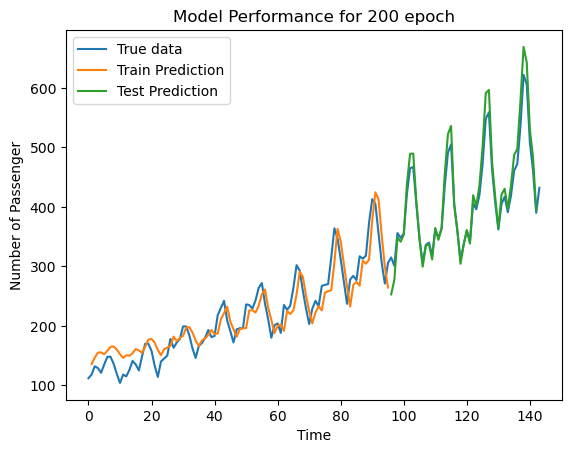

In [110]:
Predict_trainPlot = np.empty_like(Data)
Predict_testPlot = np.empty_like(Data)
Predict_trainPlot[:, :] = np.nan
Predict_testPlot[:, :] = np.nan
Predict_trainPlot[prev:len(Predict_train)+prev, :] = Predict_train
Predict_testPlot[len(Predict_train)+(prev):len(data)-1, :] = Predict_test
plt.plot(scaler.inverse_transform(Data))
plt.plot(Predict_trainPlot)
plt.plot(Predict_testPlot)
plt.xlabel("Time")
plt.ylabel("Number of Passenger")
plt.title("Model Performance for 200 epoch")
plt.legend(['True data', 'Train Prediction','Test Prediction'])
plt.savefig("out200.pdf")
plt.show()


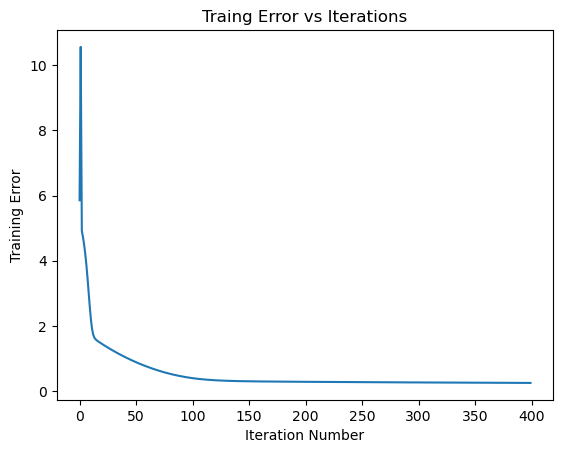

In [23]:
plt.plot(Loss)
plt.xlabel("Iteration Number")
plt.ylabel("Training Error")
plt.title("Traing Error vs Iterations")
plt.savefig("loos400.pdf")
plt.show()

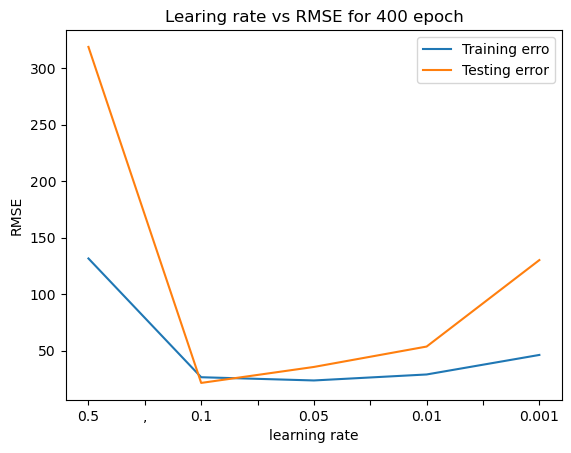

In [111]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
Train_er=[131.66,26.55,23.69,28.99,46.28]
test_er=[318.89,21.51,35.65,53.70,130.24]
plt.plot(Train_er)
plt.plot(test_er)

# We need to draw the canvas, otherwise the labels won't be positioned and 
# won't have values yet.
fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
#labels[1] = 'Testing'
labels=['','0.5',',','0.1','','0.05','','0.01','','0.001']
ax.set_xticklabels(labels)
plt.xlabel("learning rate")
plt.ylabel("RMSE")
plt.title("Learing rate vs RMSE for 400 epoch")
plt.legend([ 'Training erro','Testing error'])
plt.savefig("lr.pdf")
plt.show()